In [1]:
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import tensorflow as tf
from tensorflow import keras

In [2]:
def fmnist_tuner(hyper_parameters):
    # tuning parameters
    conv_units = hyper_parameters.Int('conv_units',
                                      min_value= 32,
                                      max_value=128,
                                      step = 32)
    dense_units = hyper_parameters.Int('dense_units',
                                       min_value=32,
                                       max_value=256,
                                       step=32)
    test_learning_rates = hyper_parameters.Choice('learning_rate',
                                                  values = [0.0001, 0.001, 0.01, 0.03,
                                                            0.05, 0.08, 0.1, 0.3])
    
    #model to tune
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(keras.layers.MaxPooling2D(2,2))
    model.add(keras.layers.Flatten(input_shape = (28,28,1)))
   
    model.add(keras.layers.Dense(units = dense_units, activation = 'relu'))
    model.add(keras.layers.Dense(10, activation = 'softmax'))
    
    #optimizer tuning
   
    
    model.compile(optimizer=keras.optimizers.Adadelta(learning_rate = test_learning_rates),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model  

In [3]:
def plot_training(model_history, measure):
    plt.plot(model_history.history[measure])
    plt.plot(model_history.history['val_'+measure])
    plt.xlabel('Epochs')
    plt.ylabel(measure)
    plt.legend(['training '+ measure,'validation '+ measure])
    plt.show()



In [4]:
#import the dataset
(training_images, training_labels),\
(validation_images, validation_labels) = keras.datasets.fashion_mnist.load_data()

# Normalize the image data
training_images = training_images.reshape(-1,28,28,1) / 255.0
validation_images = validation_images.reshape(-1,28,28,1) /255.0

In [5]:
#verify data set shapes are as expected
print(training_images.shape)
print(training_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [6]:

#Keras model for image classification
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(288, activation='relu'),
    tf.keras.layers.Dense(288, activation='relu'),
    tf.keras.layers.Dense(10, activation ='softmax')
])

model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.001),
              loss ='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [22]:
history = model.fit(training_images, 
                    training_labels,
                    validation_data = (validation_images, validation_labels),
                    epochs=100,
                    batch_size = 4000,
                    verbose=1
                   )

Epoch 1/100
15/15 [==============================] - 2s 84ms/step - loss: 1.2706 - accuracy: 0.5401 - val_loss: 0.7248 - val_accuracy: 0.7390
Epoch 2/100
15/15 [==============================] - 1s 75ms/step - loss: 0.6909 - accuracy: 0.7491 - val_loss: 0.6137 - val_accuracy: 0.7617
Epoch 3/100
15/15 [==============================] - 1s 76ms/step - loss: 0.5648 - accuracy: 0.7871 - val_loss: 0.5747 - val_accuracy: 0.7795
Epoch 4/100
15/15 [==============================] - 1s 75ms/step - loss: 0.5234 - accuracy: 0.8030 - val_loss: 0.5519 - val_accuracy: 0.7979
Epoch 5/100
15/15 [==============================] - 1s 75ms/step - loss: 0.4800 - accuracy: 0.8230 - val_loss: 0.4474 - val_accuracy: 0.8382
Epoch 6/100
15/15 [==============================] - 1s 76ms/step - loss: 0.4355 - accuracy: 0.8403 - val_loss: 0.4547 - val_accuracy: 0.8285
Epoch 7/100
15/15 [==============================] - 1s 75ms/step - loss: 0.4129 - accuracy: 0.8485 - val_loss: 0.4034 - val_accuracy: 0.8541
Epoch 

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[2000,28,28,1] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[2000,28,28,1] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext/_2]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_56085]

Function call stack:
test_function -> test_function


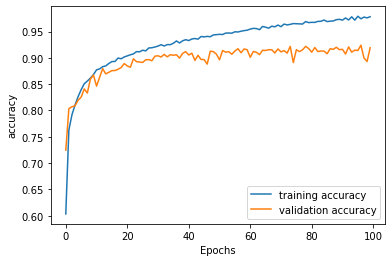

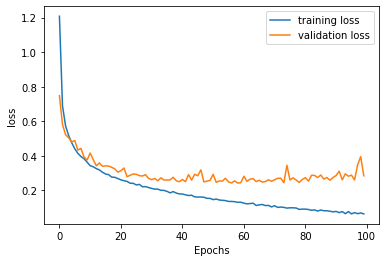

In [20]:
plot_training(history, 'accuracy')
plot_training(history, 'loss')

In [ ]:
batch_sizes=[6000,4000,3000,2000,1500,1000,750,500,250,200,125,100,50,25]

optimal_hyperparameters = []

for size in batch_sizes:
    tuner= kt.Hyperband(fmnist_tuner,
                         objective='val_accuracy',
                         max_epochs=20,
                         factor=3,
                         directory='models',
                         project_name=f'fmnist_with_cnn_batch{size}')
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)
    
    tuner.search(training_images, training_labels,
                 epochs = 50,
                 validation_split = 0.2,
                 batch_size=size)
    best_params = tuner.get_best_hyperparameters(num_trials=1)[0]
    dense_output = best_params.get('dense_units')
    learning_output = best_params.get('learning_rate')
    filters_output = best_params.get('conv_units')
    
    batch_results = (f'batch_size = {size}',
                     f'Dense units: {dense_output}',
                     f'Learning rate: {learning_output}',
                     f'Conv filters: {filters_output}'
)
    print(batch_results)
    optimal_hyperparameters.append(batch_results)

np.savetxt('optimal_hyperparameters.txt', 
           np.array(optimal_hyperparameters),
           fmt="%s")